<a href="https://colab.research.google.com/github/crystal-zhu/Sitcom_Success_Factors-CSDS_312/blob/main/Sitcom_Success_Factors_Friends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing

In [ ]:
# import necessary packages
import requests
from bs4 import BeautifulSoup
import pandas as pd
from textblob import TextBlob
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
import re

from collections import Counter
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download("averaged_perceptron_tagger")
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install nltk

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# website with every episode script from friends
url = 'https://fangj.github.io/friends/'

In [ ]:
page = requests.get(url)

# parse HTML content
soup = BeautifulSoup(page.text, 'html.parser')

In [ ]:
# find all <a> tags for the hyperlinks
links = soup.find_all('a')

In [ ]:
# Function to extract season number
def extract_season(episode_code):
    if '-' in episode_code:
        # If there's a hyphen, use the first digit(s) to determine the correct season
        return int(episode_code[0])  # First digit for season
    elif len(episode_code.strip()) == 4:
        # Extract the first two characters if the code is longer than 3 characters
        return int(episode_code[:2])
    else:
        # Extract the first character otherwise
        return int(episode_code[0])

# Function to extract episode number
def extract_episode(episode_code):
    if '-' in episode_code:
        # If there's a hyphen, consider the first part as the episode number
        return episode_code.split('-')[0]  # Get the first part
    elif len(episode_code.strip()) >= 4:
        # Get the remaining characters after the first two
        return episode_code[2:]
    else:
        # Get the remaining characters after the first
        return episode_code[1:]

# empty list to store script data
script_data = []

# empty dictionary
script_dict = {}

# counter to keep track of number of episodes
count = 0

# loop through each link
for link in links:
    text_parts = link.get_text().split(' ')

    # Extract season and episode
    episode_code = text_parts[0].strip()
    season = extract_season(episode_code)  # Correct extraction of season
    episode = extract_episode(episode_code)  # Correct extraction of episode

    # Extract episode name
    episode_name = ' '.join(text_parts[1:]).strip()

    # concatenate the full URL for the episode script
    episode_url = url + link['href']
    episode_r = requests.get(episode_url)
    episode_soup = BeautifulSoup(episode_r.text, 'html.parser')

    # find all paragraphs/dialogues
    dialogues = episode_soup.find_all('p')
    start_script = True

    # loop through the dialogues
    for d in dialogues:
        dialogue = d.get_text()

        # splits between the character's name and their dialogue
        dialogue_split = dialogue.split(':')

        # gets the character and their line
        if start_script and len(dialogue_split) > 1:
            character = dialogue_split[0].strip()
            line = dialogue_split[1].strip()

            # append to dictionary
            script_data.append({
                'season': season,
                'episode': episode,
                'title': episode_name,
                'character': character,
                'dialogue': line
            })

    # Update the dictionary with the correct key
    script_dict[count] = script_data
    count += 1

In [ ]:
# Convert the list of dictionaries into a DataFrame
episode_df = pd.DataFrame(script_data)
episode_df['character'] = episode_df['character'].str.capitalize()
episode_df

,season,episode,title,character,dialogue
0,1,01,Monica Gets A Roommate,Written by,Marta Kauffman & David Crane
1,1,01,Monica Gets A Roommate,Monica,There's nothing to tell! He's just some guy\nI...
2,1,01,Monica Gets A Roommate,Joey,"C'mon, you're going out with the guy! There's\..."
3,1,01,Monica Gets A Roommate,Chandler,"All right Joey, be\nnice. So does he have a h..."
4,1,01,Monica Gets A Roommate,Phoebe,"Wait, does he eat chalk?"
...,...,...,...,...,...
59395,1,1017,"The Last One, Part I & II",Chandler,"Oh, it's gonna be okay."
59396,1,1017,"The Last One, Part I & II",Rachel,(crying) Do you guys have to go to the new hou...
59397,1,1017,"The Last One, Part I & II",Monica,We got some time.
59398,1,1017,"The Last One, Part I & II",Rachel,"Okay, should we get some coffee?"


In [ ]:
# indicate which rows where character is one of the six main characters
is_char = episode_df.character.isin(['Phoebe','Ross','Chandler','Joey','Monica','Rachel'])

In [ ]:
episode_char_df = episode_df[is_char]

In [ ]:
episode_char_df

,season,episode,title,character,dialogue
1,1,01,Monica Gets A Roommate,Monica,There's nothing to tell! He's just some guy\nI...
2,1,01,Monica Gets A Roommate,Joey,"C'mon, you're going out with the guy! There's\..."
3,1,01,Monica Gets A Roommate,Chandler,"All right Joey, be\nnice. So does he have a h..."
4,1,01,Monica Gets A Roommate,Phoebe,"Wait, does he eat chalk?"
5,1,01,Monica Gets A Roommate,Phoebe,"Just, 'cause, I don't want her to go through\n..."
...,...,...,...,...,...
59395,1,1017,"The Last One, Part I & II",Chandler,"Oh, it's gonna be okay."
59396,1,1017,"The Last One, Part I & II",Rachel,(crying) Do you guys have to go to the new hou...
59397,1,1017,"The Last One, Part I & II",Monica,We got some time.
59398,1,1017,"The Last One, Part I & II",Rachel,"Okay, should we get some coffee?"


In [ ]:
# a function to preprocess data (tokenize and remove stopwords)
def preprocess_data(doc_set):

    # extract words
    tokenizer = RegexpTokenizer(r"\b\w+(?:'\w+)?\b")

    # English stopwords
    en_stop = set(stopwords.words("english"))

    # add custom stopwords
    custom_stopwords = set(['oh', 'go', 'uh', "i'm", 'ok', 'yeah', 'okay', 'dont', 'um', 'get', 'go', 'know'])
    en_stop = en_stop.union(custom_stopwords)

    # List to hold tokenized and preprocessed texts
    texts = []

    # Loop through document list
    for doc in doc_set:

        # converts to lowercase
        raw = doc.lower()

        # tokentize into words
        tokens = tokenizer.tokenize(raw)

        # removes stopwords
        stopped_tokens = [t for t in tokens if t not in en_stop]

        # append preprocessed text to list
        texts.append(stopped_tokens)

    return texts

def preprocess_dialog(dialog):
    """
    Preprocess text (tokenize, remove stopwords, and stem).
    """
    tokenizer = RegexpTokenizer(r"\b\w+(?:'\w+)?\b")  # Tokenizer to extract words with or without apostrophes
    en_stop = set(stopwords.words("english"))  # English stopwords

    # Add custom stopwords
    custom_stopwords = set(['oh', 'go', 'uh', 'im', 'ok', 'yeah', 'okay', 'dont', 'um', 'get', 'go', 'know'])
    en_stop = en_stop.union(custom_stopwords)

    dialog = dialog.lower()  # Convert to lowercase
    tokens = tokenizer.tokenize(dialog)  # Tokenize into words
    stopped_tokens = [t for t in tokens if t not in en_stop]  # Remove stopwords
    processed_dialog = ' '.join(stopped_tokens) #put the tokens back into a big string

    return processed_dialog # Output: Single string of preprocessed dialogue for each episode

In [ ]:
# convert the 'dialogue' column from the DataFrame for each character into a list
phoebe_text = list(episode_char_df[episode_char_df.character == 'Phoebe'].dialogue)
ross_text = list(episode_char_df[episode_char_df.character == 'Ross'].dialogue)
chandler_text = list(episode_char_df[episode_char_df.character == 'Chandler'].dialogue)
joey_text = list(episode_char_df[episode_char_df.character == 'Joey'].dialogue)
monica_text = list(episode_char_df[episode_char_df.character == 'Monica'].dialogue)
rachel_text = list(episode_char_df[episode_char_df.character == 'Rachel'].dialogue)

In [ ]:
# apply preprocessing function to each of the character's dialogue list
phoebe_preprocessed = preprocess_data(phoebe_text)
ross_preprocessed = preprocess_data(ross_text)
chandler_preprocessed = preprocess_data(chandler_text)
joey_preprocessed = preprocess_data(joey_text)
monica_preprocessed = preprocess_data(monica_text)
rachel_preprocessed = preprocess_data(rachel_text)

# Sentiment Analysis (Emotions)

In [ ]:
!pip install -q transformers
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification, pipeline

tokenizer = RobertaTokenizerFast.from_pretrained("arpanghoshal/EmoRoBERTa")
model = TFRobertaForSequenceClassification.from_pretrained("arpanghoshal/EmoRoBERTa")

emotion_pipeline = pipeline('sentiment-analysis',
                    model='arpanghoshal/EmoRoBERTa')

In [ ]:
print(len(episode_df))
buffer_df = episode_df

# 'Phoebe','Ross','Chandler','Joey','Monica','Rachel'

# Apply the mask to the DataFrame to keep rows not containing values to drop
buffer_df.replace('', np.nan, inplace=True)
buffer_df.replace('Written by', np.nan, inplace=True)

mask = buffer_df['character'].isin(['Ross', 'Joey', 'Chandler', 'Phoebe', 'Monica', 'Rachel'])
# mask = buffer_df['character'].isin(['ALL'])

filtered_df = (buffer_df[mask]).dropna()


print(len(filtered_df))

59400
45094


In [ ]:
count = 0;
for item in filtered_df['dialogue'].values.tolist():
  if not isinstance(item, str):
    count += 1
print(count)

0


In [ ]:
sample_dialogues = 15000
filtered_df = filtered_df.head(sample_dialogues)

# print(type([0,1]))
# print(type(filtered_df['dialogue'].values))
# # episode_df['dialogue'][4228] == ''

emotion_data_list = emotion_pipeline( filtered_df['dialogue'].values.tolist() )

emotion_list = [emotion["label"] for emotion in emotion_data_list]
character_list = filtered_df['character'].values.tolist()

print(filtered_df.head()['dialogue'].values.tolist())

["There's nothing to tell! He's just some guy\nI work with!", "C'mon, you're going out with the guy! There's\ngotta be something wrong with him!", 'All right Joey, be\nnice.\xa0 So does he have a hump? A hump and a hairpiece?', 'Wait, does he eat chalk?', "Just, 'cause, I don't want her to go through\nwhat I went through with Carl- oh!"]


In [ ]:
# Adding emotions list into the dataframe
filtered_df['emotion'] = emotion_list
print(len(filtered_df))
filtered_df

NameError: name 'emotion_list' is not defined

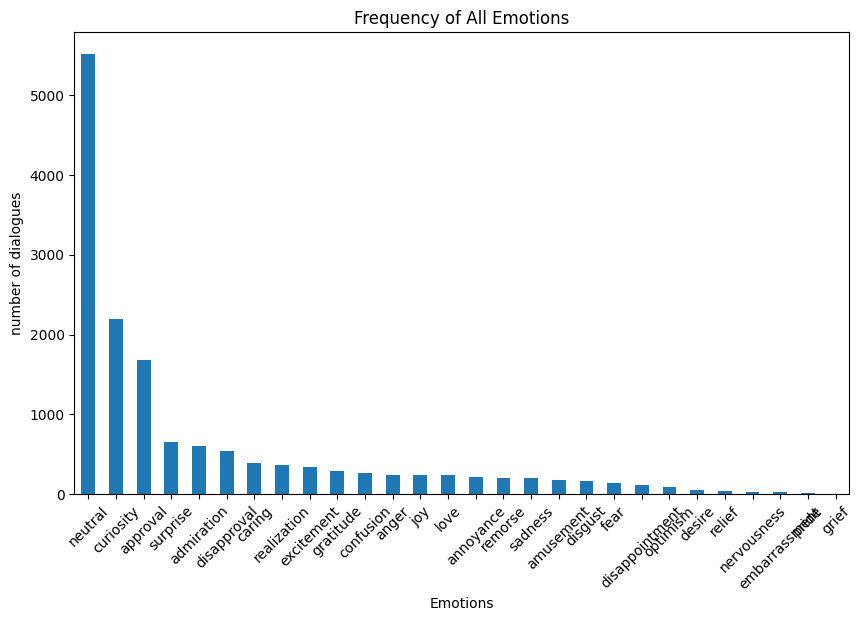

In [ ]:
# Plotting the histogram
plt.figure(figsize=(10, 6))  # Set the size of the plot
filtered_df['emotion'].value_counts().plot(kind='bar')  # Plot the histogram
plt.title('Frequency of All Emotions')  # Add title to the plot
plt.xlabel('Emotions')  # Add x-label to the plot
plt.ylabel('number of dialogues')  # Add y-label to the plot
plt.xticks(rotation=45)  # Rotate x-labels for better readability
plt.show()  # Show the plot

In [ ]:
roberta_emotions = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity',
    'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
    'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
    'remorse', 'sadness', 'surprise', 'neutral'
]

select_emotions = [
    'admiration', 'amusement', 'anger', 'annoyance', 'disappointment', 'disapproval',
    'disgust', 'excitement', 'fear',  'joy', 'love', 'sadness', 'surprise', 'nervousness'
]


mask = filtered_df['emotion'].isin(select_emotions)
select_emotions_df = filtered_df[mask]
select_emotions_df.replace('disgust', 'annoyance', inplace=True)
select_emotions_df.replace('nervousness', 'fear', inplace=True)
select_emotions_df.replace('love', 'love/joy', inplace=True)
select_emotions_df.replace('joy', 'love/joy', inplace=True)
select_emotions_df.replace('sadness', 'annoyance/sad/disappointed', inplace=True)
select_emotions_df.replace('disappointment', 'annoyance/sad/disappointed', inplace=True)
select_emotions_df.replace('annoyance', 'annoyance/sad/disappointed', inplace=True)

select_emotions_df

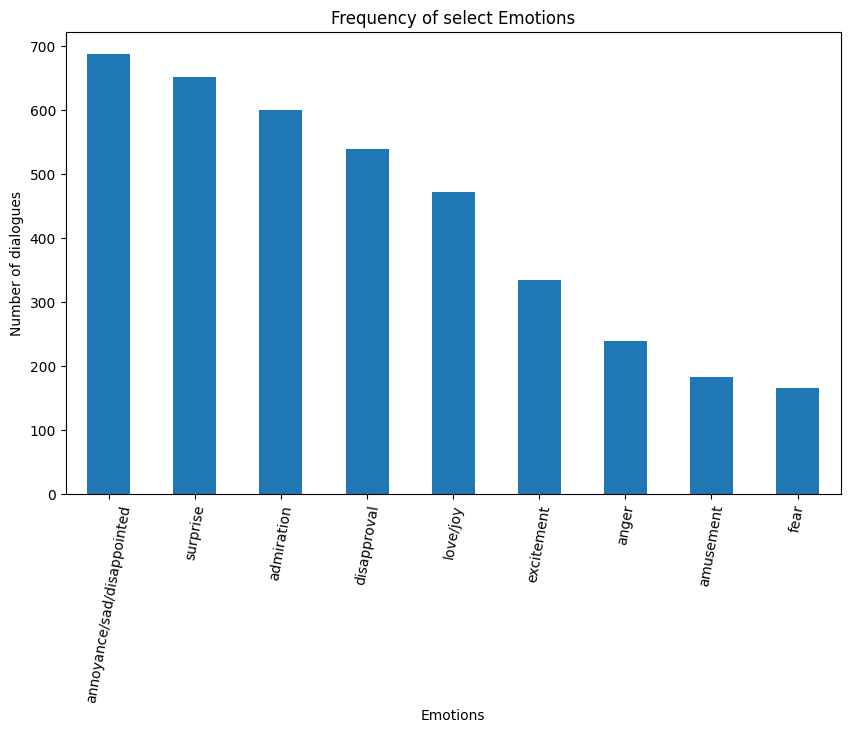

In [ ]:
# Plotting the histogram
plt.figure(figsize=(10, 6))  # Set the size of the plot
select_emotions_df['emotion'].value_counts().plot(kind='bar')  # Plot the histogram
plt.title('Frequency of select Emotions')  # Add title to the plot
plt.xlabel('Emotions')  # Add x-label to the plot
plt.ylabel('Number of dialogues')  # Add y-label to the plot
plt.xticks(rotation=80)  # Rotate x-labels for better readability
plt.show()  # Show the plot

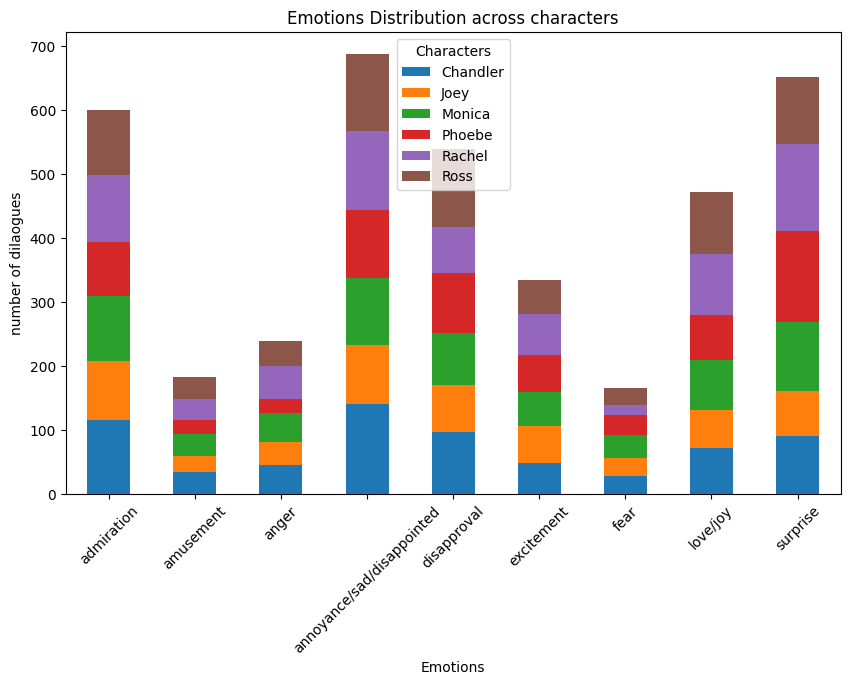

In [ ]:
counts = select_emotions_df.groupby(['emotion', 'character']).size().unstack(fill_value=0)

# Plotting the bar plot
counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Emotions Distribution across characters')
plt.xlabel('Emotions')
plt.ylabel('number of dilaogues')
plt.xticks(rotation=45)
plt.legend(title='Characters')
plt.show()

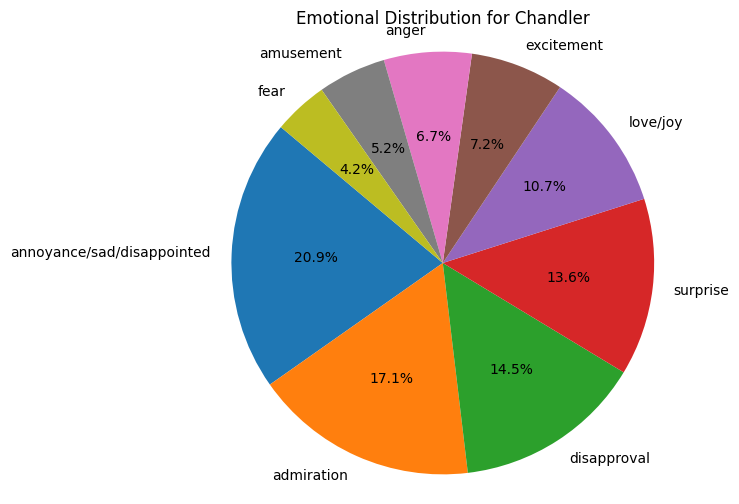

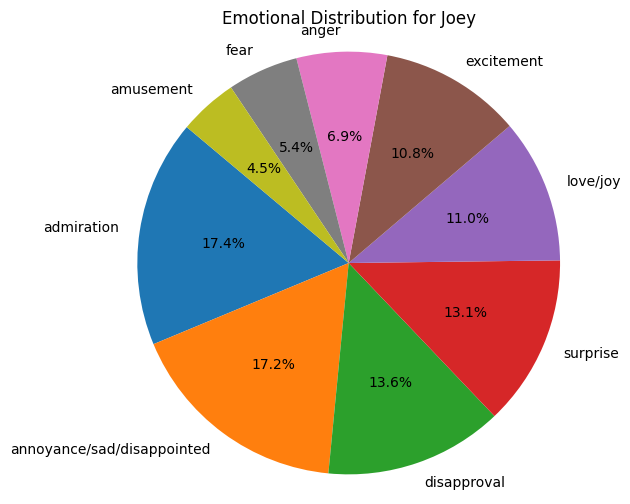

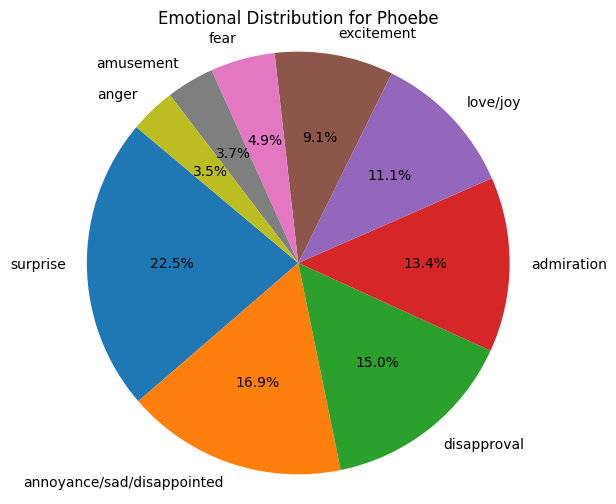

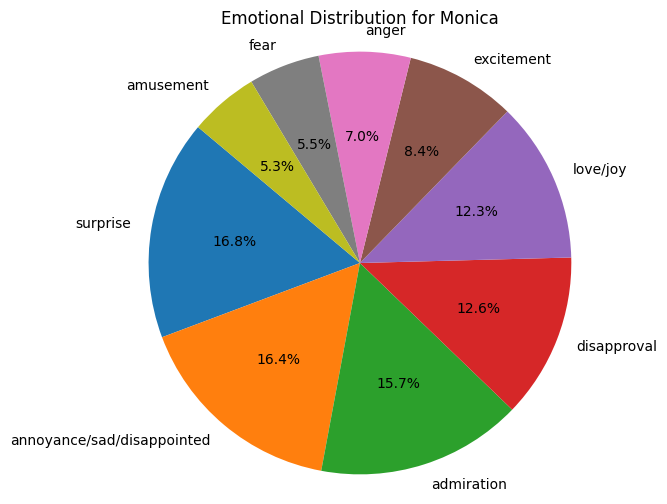

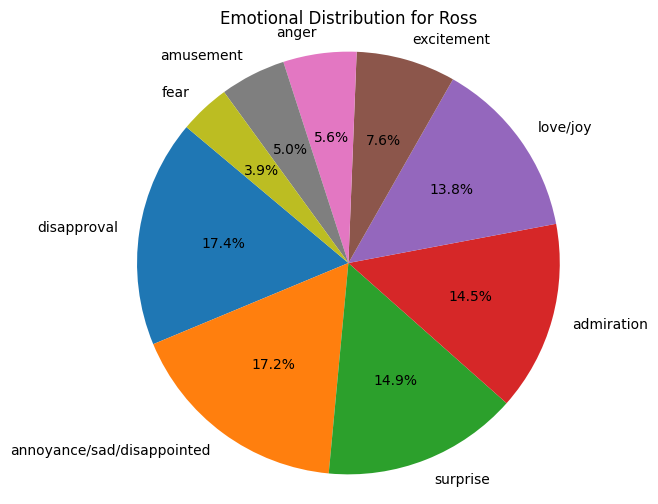

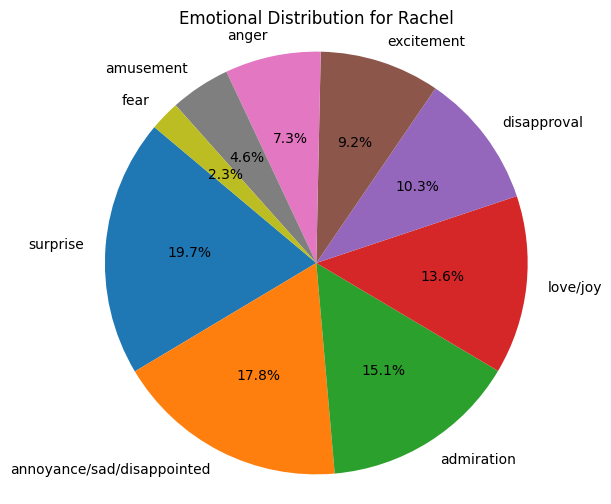

In [ ]:
df = select_emotions_df

# Get unique characters
characters = df['character'].unique()

# Plot pie chart for each character
for character in characters:
    # Filter DataFrame for the current character
    character_df = df[df['character'] == character]

    # Count the occurrences of each emotion for the character
    emotion_counts = character_df['emotion'].value_counts()

    # Plotting the pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Emotional Distribution for {character}')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.show()

# Top 20 Most Spoken Words

In [ ]:
# a function to flatten the list of lists into a single list
def flatten_list(nested_list):
    return [item for sublist in nested_list for item in sublist]

# flatten the preprocessed dialogues for each of the characters
phoebe_words = flatten_list(phoebe_preprocessed)
ross_words = flatten_list(ross_preprocessed)
chandler_words = flatten_list(chandler_preprocessed)
joey_words = flatten_list(joey_preprocessed)
monica_words = flatten_list(monica_preprocessed)
rachel_words = flatten_list(rachel_preprocessed)

In [ ]:
# a function to return the top 20 most common words
def get_top_20_words(word_list):

    # count the frequency of each word
    word_counts = Counter(word_list)
    return word_counts.most_common(20)

top_20_phoebe = get_top_20_words(phoebe_words)
top_20_ross = get_top_20_words(ross_words)
top_20_chandler = get_top_20_words(chandler_words)
top_20_joey = get_top_20_words(joey_words)
top_20_monica = get_top_20_words(monica_words)
top_20_rachel = get_top_20_words(rachel_words)

In [ ]:
# print the top 20 words spoken by each main character
print("Top 20 words used by Phoebe:", top_20_phoebe)
print("Top 20 words used by Ross:", top_20_ross)
print("Top 20 words used by Chandler:", top_20_chandler)
print("Top 20 words used by Joey:", top_20_joey)
print("Top 20 words used by Monica:", top_20_monica)
print("Top 20 words used by Rachel:", top_20_rachel)

Top 20 words used by Phoebe: [('well', 494), ('like', 438), ('hey', 399), ('right', 380), ('really', 344), ('gonna', 320), ('one', 292), ('monica', 280), ('god', 254), ('rachel', 246), ('look', 241), ('ross', 238), ('good', 230), ('joey', 222), ('think', 220), ('see', 209), ('chandler', 203), ('guys', 185), ("y'know", 183), ('want', 179)]
Top 20 words used by Ross: [('hey', 690), ('well', 519), ('right', 471), ('like', 423), ('rachel', 417), ('gonna', 356), ('mean', 352), ('look', 337), ('think', 314), ('really', 304), ('joey', 284), ('one', 280), ('see', 263), ('come', 257), ('chandler', 250), ('want', 244), ('guys', 244), ('going', 224), ('good', 223), ('would', 217)]
Top 20 words used by Chandler: [('well', 527), ('hey', 444), ('right', 420), ('gonna', 369), ('monica', 367), ('like', 365), ('joey', 347), ('look', 322), ('think', 320), ('one', 271), ('really', 269), ('ross', 266), ('yes', 241), ('see', 240), ('got', 208), ('mean', 206), ('good', 204), ("that's", 186), ('say', 186), (

# Top 10 Adjectives

In [ ]:
# a function to clean and tokenize the text
def clean_and_tokenize(text):

    # remove leading/trailing spaces
    text = text.strip()

    # allow only words, apostrophes, and dashes
    text = re.sub(r"[^\w'-]"," ",text)

    # replace multiple spaces with a single space
    text = re.sub(r"\s+", " ", text)

    return nltk.word_tokenize(text)

In [ ]:
# a function to extract the adjectives
def extract_adjectives(text):
    words = clean_and_tokenize(text)

    # Apply part-of-speech tagging to identify adjectives
    tagged_words = nltk.pos_tag(words)
    adjectives = [word for (word, tag) in tagged_words if tag.startswith("JJ")]
    return adjectives

In [ ]:
# a function to retrieve the adjectives
def get_all_adjectives(dialogues):
    adjectives = []
    for dialogue in dialogues:
        adjectives.extend(extract_adjectives(dialogue))
    return adjectives

In [ ]:
# gets the adjectives spoken by each of the main characters
phoebe_adjectives = get_all_adjectives(phoebe_words)
ross_adjectives = get_all_adjectives(ross_words)
chandler_adjectives = get_all_adjectives(chandler_words)
joey_adjectives = get_all_adjectives(joey_words)
monica_adjectives = get_all_adjectives(monica_words)
rachel_adjectives = get_all_adjectives(rachel_words)

In [ ]:
# a function to get only the top 10 adjectives
def get_top_10_adjectives(adjective_list):
    adjective_counts = Counter(adjective_list)
    return adjective_counts.most_common(10)

In [ ]:
top_10_phoebe = get_top_10_adjectives(phoebe_adjectives)
top_10_ross = get_top_10_adjectives(ross_adjectives)
top_10_chandler = get_top_10_adjectives(chandler_adjectives)
top_10_joey = get_top_10_adjectives(joey_adjectives)
top_10_monica = get_top_10_adjectives(monica_adjectives)
top_10_rachel = get_top_10_adjectives(rachel_adjectives)

In [ ]:
# prints the top 10 adjectives spoken by each character
print("Top 10 adjectives used by Phoebe:", top_10_phoebe)
print("Top 10 adjectives used by Ross:", top_10_ross)
print("Top 10 adjectives used by Chandler:", top_10_chandler)
print("Top 10 adjectives used by Joey:", top_10_joey)
print("Top 10 adjectives used by Monica:", top_10_monica)
print("Top 10 adjectives used by Rachel:", top_10_rachel)

Top 10 adjectives used by Phoebe: [('good', 230), ('great', 139), ('little', 130), ('much', 80), ('happy', 60), ('big', 56), ('bad', 54), ('last', 51), ('nice', 51), ('new', 49)]
Top 10 adjectives used by Ross: [('good', 223), ('great', 181), ('little', 175), ('much', 96), ('big', 85), ('new', 67), ('last', 64), ('married', 63), ('nice', 63), ('whole', 50)]
Top 10 adjectives used by Chandler: [('good', 204), ('great', 160), ('little', 144), ('big', 107), ('last', 83), ('much', 74), ('new', 69), ('nice', 68), ('bad', 59), ('married', 53)]
Top 10 adjectives used by Joey: [('good', 243), ('little', 183), ('great', 179), ('big', 109), ('much', 86), ('new', 70), ('nice', 69), ('next', 60), ('best', 57), ('hot', 52)]
Top 10 adjectives used by Monica: [('good', 189), ('little', 154), ('great', 148), ('much', 106), ('big', 80), ('married', 61), ('bad', 59), ('nice', 57), ('new', 54), ('best', 52)]
Top 10 adjectives used by Rachel: [('good', 212), ('great', 206), ('little', 185), ('much', 111),

In [ ]:
# a function to create a word cloud
def generate_word_cloud(top_words, title):

    # create a word cloud from word frequencies
    word_cloud = WordCloud(
        width=800,
        height=400,
        background_color="white"
    ).generate_from_frequencies(dict(top_words))

    # plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

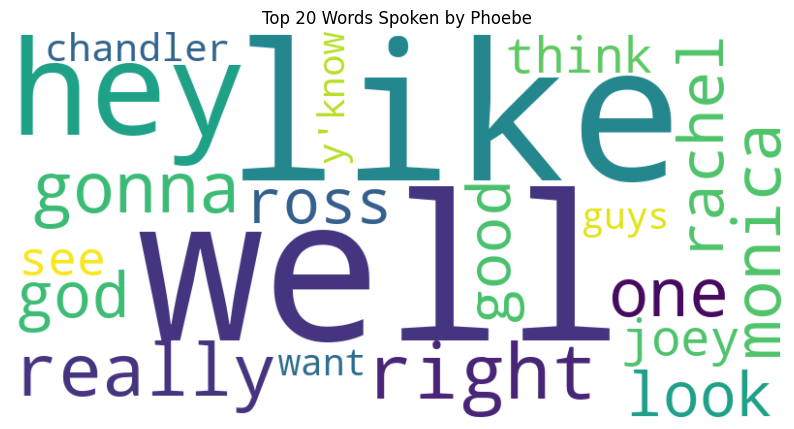

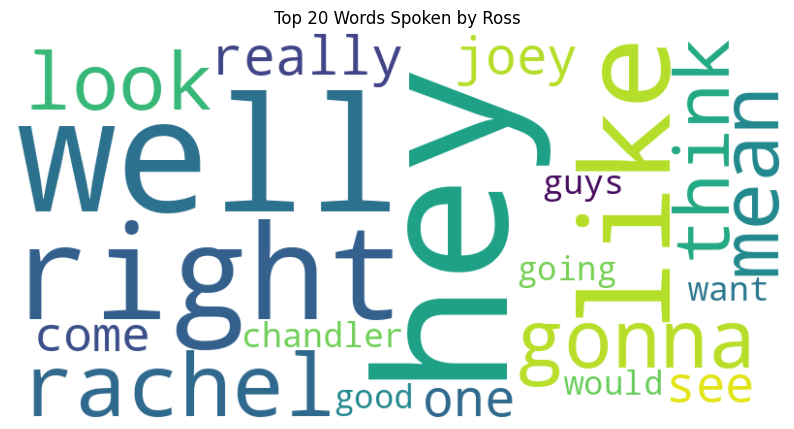

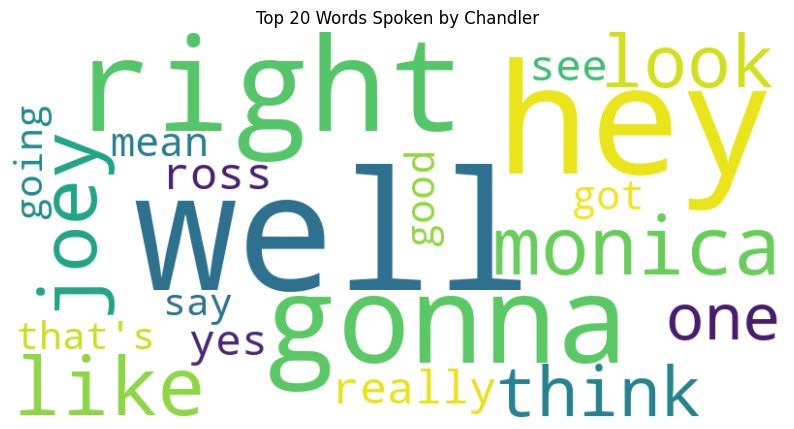

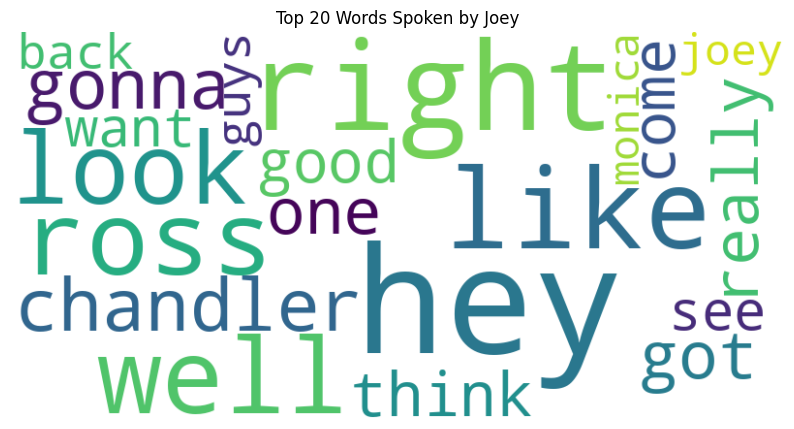

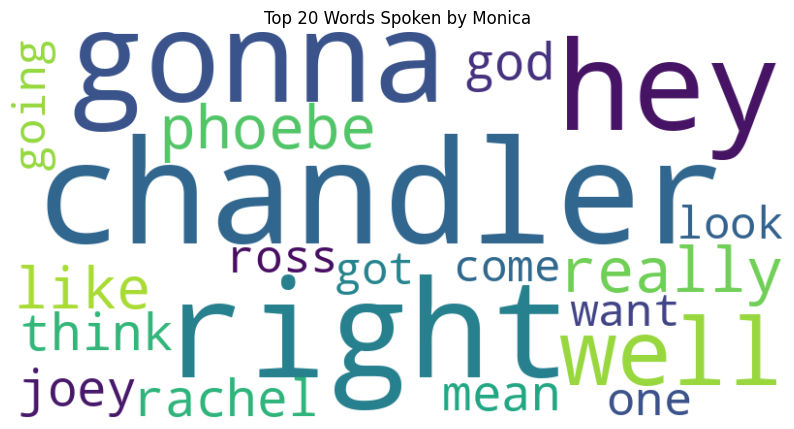

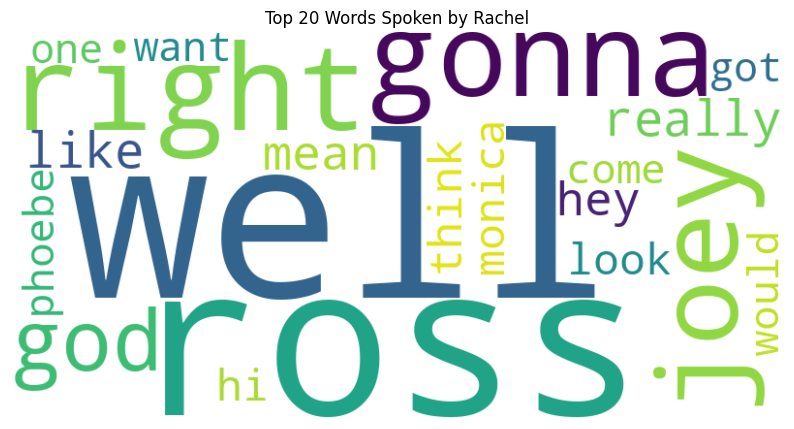

In [ ]:
# word cloud for each of the main character's top 20 most commonly spoken words
generate_word_cloud(top_20_phoebe, "Top 20 Words Spoken by Phoebe")
generate_word_cloud(top_20_ross, "Top 20 Words Spoken by Ross")
generate_word_cloud(top_20_chandler, "Top 20 Words Spoken by Chandler")
generate_word_cloud(top_20_joey, "Top 20 Words Spoken by Joey")
generate_word_cloud(top_20_monica, "Top 20 Words Spoken by Monica")
generate_word_cloud(top_20_rachel, "Top 20 Words Spoken by Rachel")

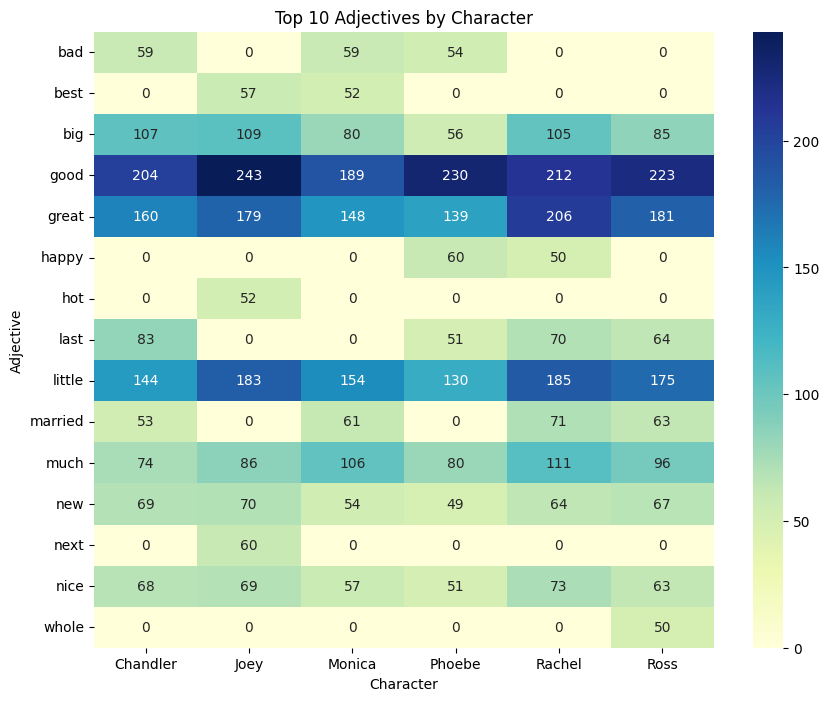

In [ ]:
data = []
main_characters = ["Rachel", "Ross", "Monica", "Chandler", "Joey", "Phoebe"]

# append data for each character
for char, top_10 in zip(main_characters, [top_10_rachel, top_10_ross, top_10_monica, top_10_chandler, top_10_joey, top_10_phoebe]):
    for adjective, count in top_10:
        data.append({'character': char, 'adjective': adjective, 'frequency': count})

# create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

# create a pivot table to get the frequency of each adjective by character
pivot_table = df.pivot_table(
    values='frequency',
    index='adjective',
    columns='character',
    fill_value=0,
    aggfunc='sum'
)

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    pivot_table,
    annot=True,
    cmap="YlGnBu",
    fmt='d',
    cbar=True
)

plt.title("Top 10 Adjectives by Character")
plt.xlabel("Character")
plt.ylabel("Adjective")
plt.show()

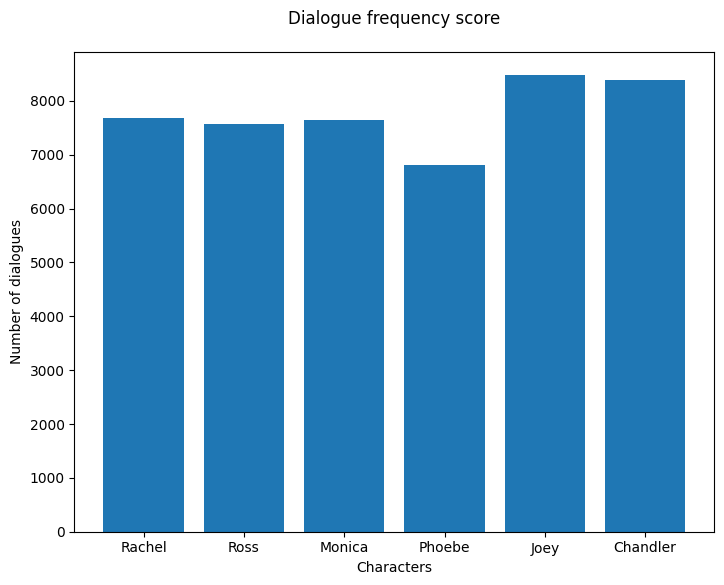

In [ ]:
lchar = [ 'Rachel','Ross','Monica','Phoebe','Joey','Chandler']

# most important character by dialogues
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Dialogue frequency score", pad=20)
plt.xlabel('Characters')
plt.ylabel('Number of dialogues')
ax.bar(lchar, episode_char_df.groupby(by=["character"]).count()['dialogue'])

plt.show()

# Relationship Storylines

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [ ]:
df = pd.read_csv('data.csv')

In [ ]:
print(df.head())

   epseason  epnum                                epname  rating  dynamics
0         1      1  The One Where Monica Gets a Roommate     8.4         3
1         1      1  The One Where Monica Gets a Roommate     8.4         5
2         1      1  The One Where Monica Gets a Roommate     8.4        56
3         1      1  The One Where Monica Gets a Roommate     8.4       126
4         1      2  The One with the Sonogram at the End     8.1         3


In [ ]:
names = ['Chandler', 'Joey', 'Monica', 'Phoebe', 'Rachel', 'Ross']

# define the main characters
chandler = 1
joey = 2
monica = 3
phoebe = 4
rachel = 5
ross = 6

In [ ]:
# define 2-person pair codes and names for the 6 main characters
pair_codes = [
    12, 13, 14, 15, 16, 23, 24, 25, 26, 34, 35, 36, 45, 46, 56
]

# combination of pairs
pairs = [
    'chandler_joey', 'chandler_monica', 'chandler_phoebe', 'chandler_rachel', 'chandler_ross',
    'joey_monica', 'joey_phoebe', 'joey_rachel', 'joey_ross',
    'monica_phoebe', 'monica_rachel', 'monica_ross',
    'phoebe_rachel', 'phoebe_ross', 'rachel_ross'
]

In [ ]:
# a function to find the frequency of each pair code from storylines
def find_pair_frequencies(pair_codes):

    # count occurrences of each pair code
    pair_freq = [
        df[df['dynamics'] == code].shape[0] for code in pair_codes
    ]

    # create a dictionary associating pair names with frequencies
    pair_freq_dict = dict(zip(pairs, pair_freq))

    return pairs, pair_freq, pair_freq_dict

In [ ]:
# find frequencies for each pair code
pairs, pair_freq, pair_freq_dict = find_pair_frequencies(pair_codes)

# print pair frequencies as a dictionary
print(pair_freq_dict)
pair_freq

{'chandler_joey': 36, 'chandler_monica': 63, 'chandler_phoebe': 6, 'chandler_rachel': 7, 'chandler_ross': 12, 'joey_monica': 7, 'joey_phoebe': 20, 'joey_rachel': 26, 'joey_ross': 14, 'monica_phoebe': 18, 'monica_rachel': 12, 'monica_ross': 4, 'phoebe_rachel': 17, 'phoebe_ross': 14, 'rachel_ross': 70}


[36, 63, 6, 7, 12, 7, 20, 26, 14, 18, 12, 4, 17, 14, 70]

<ipython-input-70-611e84b9249c>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_pair_freq, y=sorted_pair_names, palette='viridis')


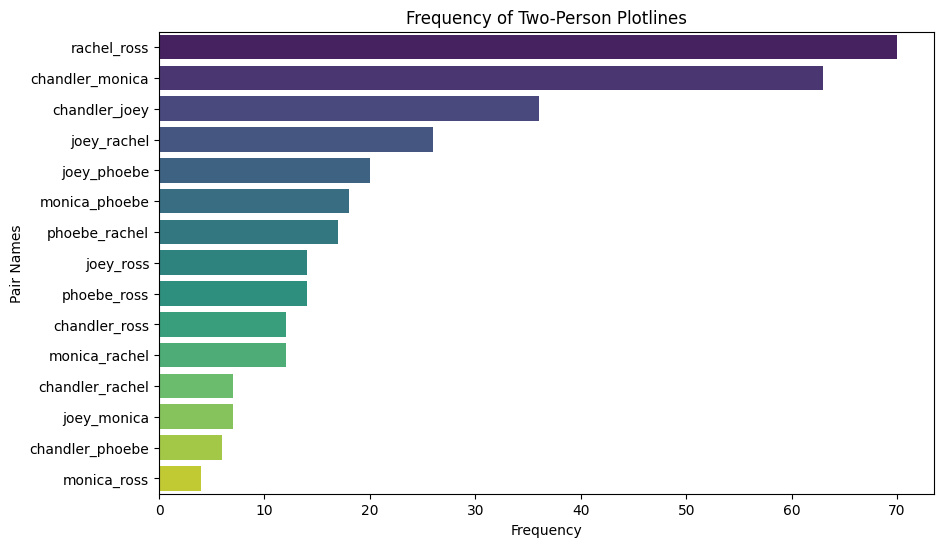

In [ ]:
# convert dictionary to a list of tuples, sort by descreasing frequency
sorted_pairs = sorted(pair_freq_dict.items(), key=lambda x: x[1], reverse=True)

# separate sorted pairs into names and frequencies for plotting
sorted_pair_names = [pair[0] for pair in sorted_pairs]
sorted_pair_freq = [pair[1] for pair in sorted_pairs]

# make a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_pair_freq, y=sorted_pair_names, palette='viridis')

plt.title('Frequency of Two-Person Plotlines')
plt.xlabel('Frequency')
plt.ylabel('Pair Names')
plt.show()

In [ ]:
# a function to get the average rating for all of the pairs
def calc_pair_rating(pair_list):

    ratings = []

    # loop through list of pairs and get average rating for each
    for pair_code in pair_list:
        ratings.append(df[df['dynamics'] == pair_code].rating.mean())

    # create a dictionary with pair names as keys and ratings as values
    pair_ratings_dict = dict(zip(pairs, ratings))

    return pairs, ratings, pair_ratings_dict

print(calc_pair_rating(pair_codes)[2])

{'chandler_joey': 8.591666666666665, 'chandler_monica': 8.622222222222224, 'chandler_phoebe': 8.583333333333334, 'chandler_rachel': 8.742857142857142, 'chandler_ross': 8.441666666666666, 'joey_monica': 8.514285714285716, 'joey_phoebe': 8.5, 'joey_rachel': 8.48076923076923, 'joey_ross': 8.52142857142857, 'monica_phoebe': 8.33888888888889, 'monica_rachel': 8.55, 'monica_ross': 8.5, 'phoebe_rachel': 8.570588235294117, 'phoebe_ross': 8.514285714285716, 'rachel_ross': 8.584285714285715}


<ipython-input-72-4f08128f7596>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_pair_ratings, y=sorted_pair_names, palette='coolwarm')


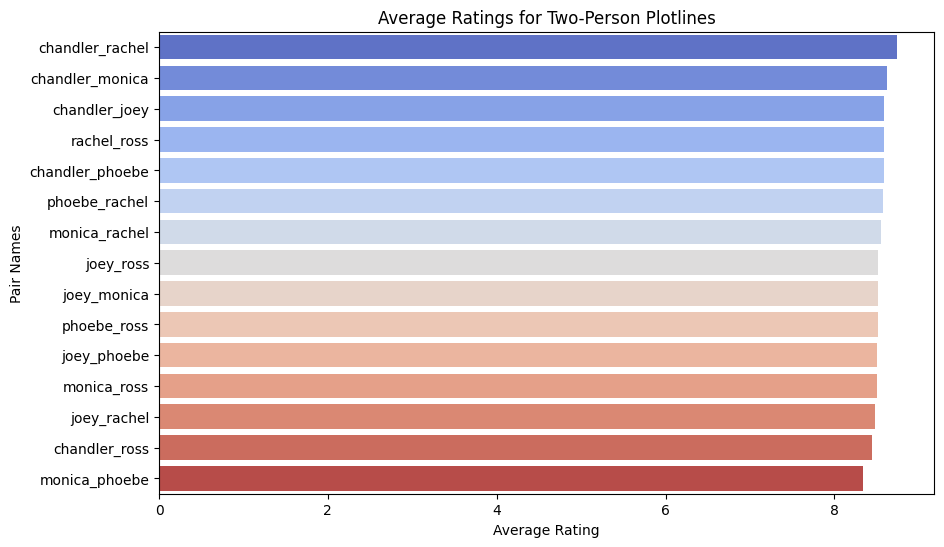

In [ ]:
# calculate the average ratings for each pair
pairs, pair_ratings, pair_ratings_dict = calc_pair_rating(pair_codes)

# sort pairs by ratings in decreasing order
sorted_ratings = sorted(pair_ratings_dict.items(), key=lambda x: x[1], reverse=True)

sorted_pair_names = [pair[0] for pair in sorted_ratings]
sorted_pair_ratings = [pair[1] for pair in sorted_ratings]

# make a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_pair_ratings, y=sorted_pair_names, palette='coolwarm')

plt.title('Average Ratings for Two-Person Plotlines')
plt.xlabel('Average Rating')
plt.ylabel('Pair Names')
plt.show()

# IMBD Ratings

In [ ]:
# create a new DataFrame to only get the unique episodes
df2 = df[['epseason','epnum','rating']]
ep_ratings = df2.drop_duplicates(subset=['epseason', 'epnum'], keep='first')

In [ ]:
# a pivot table for the ratings
heatmap_data = df2.pivot_table(
    index='epseason', columns='epnum', values='rating', aggfunc='mean'
)

In [ ]:
# to install basic fonts
!sudo apt-get update
!sudo apt-get install -y fonts-dejavu fonts-liberation

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
0% [Working]

In [ ]:
# plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=0.5)

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)
plt.title("Friends Episode IMDB Ratings")
plt.xlabel("Episode Number")
plt.ylabel("Season")
plt.show()

# Sentiment Analysis (Polarity)

In [ ]:
def combine_dialogue(dialogues):
    return ' '.join(dialogues)

In [ ]:
rachel_lines = episode_char_df[episode_char_df['character'] == 'Rachel'].copy()
ross_lines = episode_char_df[episode_char_df['character'] == 'Ross'].copy()
monica_lines = episode_char_df[episode_char_df['character'] == 'Monica'].copy()
chandler_lines = episode_char_df[episode_char_df['character'] == 'Chandler'].copy()
phoebe_lines = episode_char_df[episode_char_df['character'] == 'Phoebe'].copy()
joey_lines = episode_char_df[episode_char_df['character'] == 'Joey'].copy()

In [ ]:
rachel_lines = rachel_lines.groupby(['season', 'episode']).agg({'dialogue': combine_dialogue}).reset_index()
ross_lines = ross_lines.groupby(['season', 'episode']).agg({'dialogue': combine_dialogue}).reset_index()
monica_lines = monica_lines.groupby(['season', 'episode']).agg({'dialogue': combine_dialogue}).reset_index()
chandler_lines = chandler_lines.groupby(['season', 'episode']).agg({'dialogue': combine_dialogue}).reset_index()
phoebe_lines = phoebe_lines.groupby(['season', 'episode']).agg({'dialogue': combine_dialogue}).reset_index()
joey_lines = joey_lines.groupby(['season', 'episode']).agg({'dialogue': combine_dialogue}).reset_index()

In [ ]:
def average_sentence_sentiment(dialogue):
    sia = SentimentIntensityAnalyzer()
    sentences = sent_tokenize(dialogue)  # Tokenize dialogue into sentences
    sentiment_scores = [sia.polarity_scores(sentence)['compound'] for sentence in sentences]  # Calculate sentiment scores for each sentence
    if sentiment_scores:  # Check if there are any sentences
        return np.mean(sentiment_scores)  # Return the average sentiment score
    else:
        return 0  # Return 0 if there are no sentences (empty dialogue)


In [ ]:
rachel_lines['sentiment_score'] = rachel_lines['dialogue'].apply(average_sentence_sentiment)
ross_lines['sentiment_score'] = ross_lines['dialogue'].apply(average_sentence_sentiment)
monica_lines['sentiment_score'] = monica_lines['dialogue'].apply(average_sentence_sentiment)
chandler_lines['sentiment_score'] = chandler_lines['dialogue'].apply(average_sentence_sentiment)
phoebe_lines['sentiment_score'] = phoebe_lines['dialogue'].apply(average_sentence_sentiment)
joey_lines['sentiment_score'] = joey_lines['dialogue'].apply(average_sentence_sentiment)

In [ ]:
rachel_sentiment_stats = rachel_lines.groupby('season')['sentiment_score'].agg(['mean', 'std'])
ross_sentiment_stats = ross_lines.groupby('season')['sentiment_score'].agg(['mean', 'std'])
monica_sentiment_stats = monica_lines.groupby('season')['sentiment_score'].agg(['mean', 'std'])
chandler_sentiment_stats = chandler_lines.groupby('season')['sentiment_score'].agg(['mean', 'std'])
phoebe_sentiment_stats = phoebe_lines.groupby('season')['sentiment_score'].agg(['mean', 'std'])
joey_sentiment_stats = joey_lines.groupby('season')['sentiment_score'].agg(['mean', 'std'])

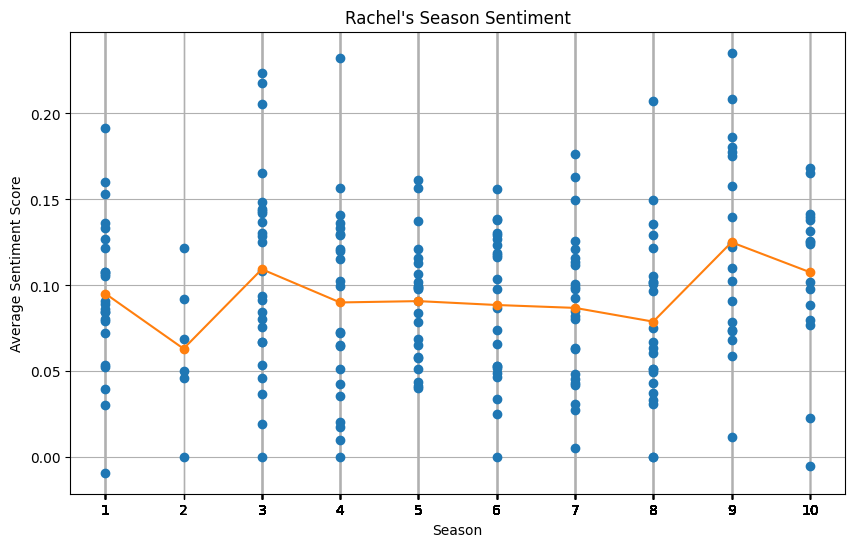

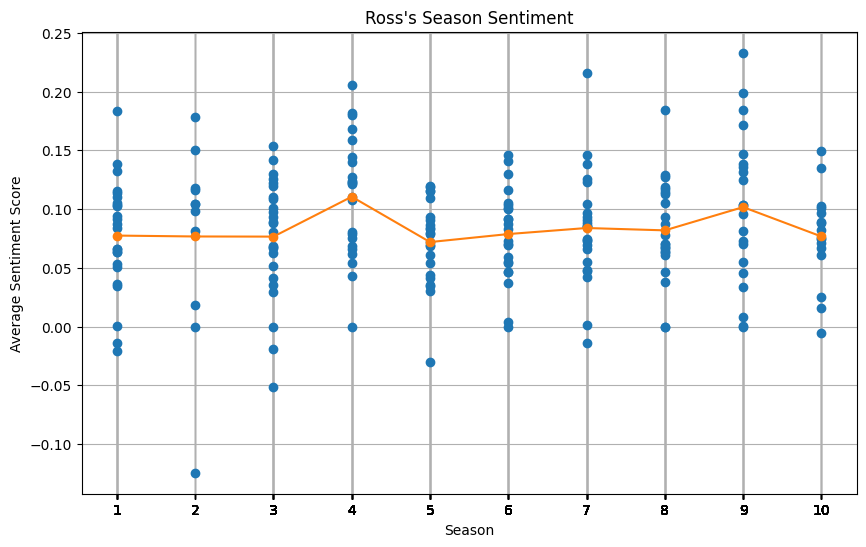

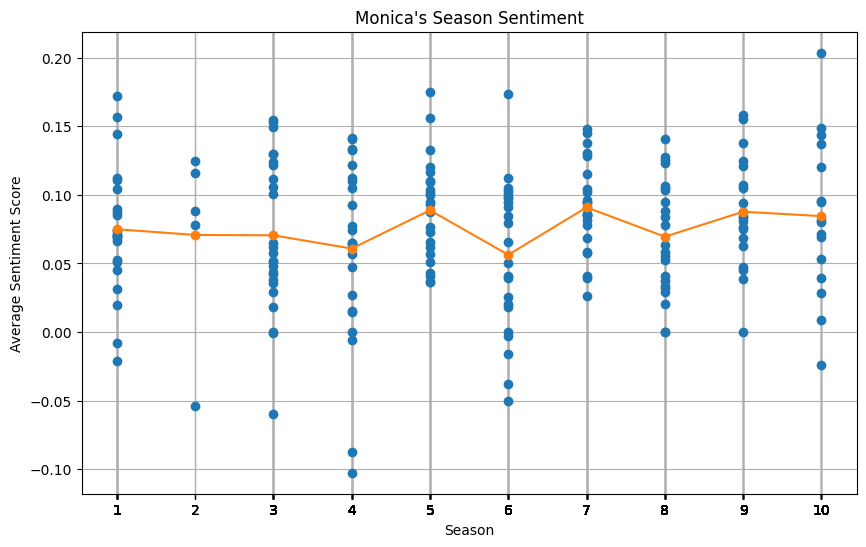

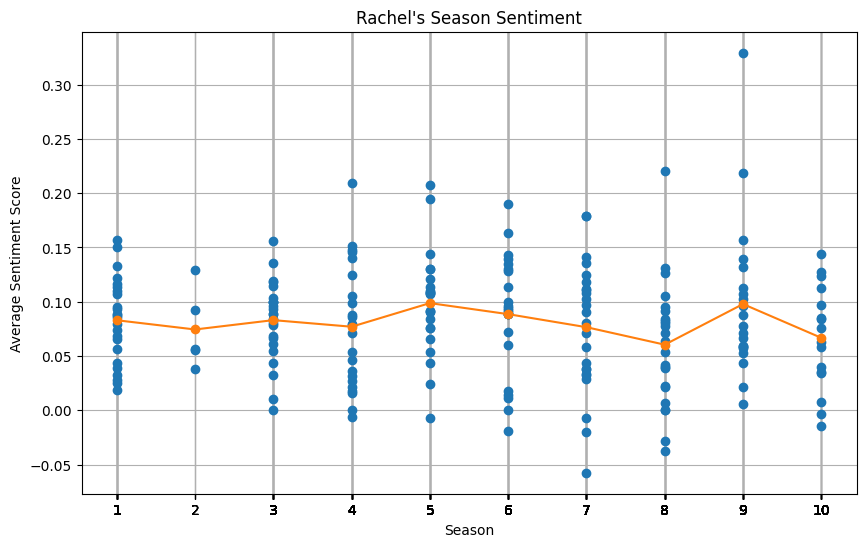

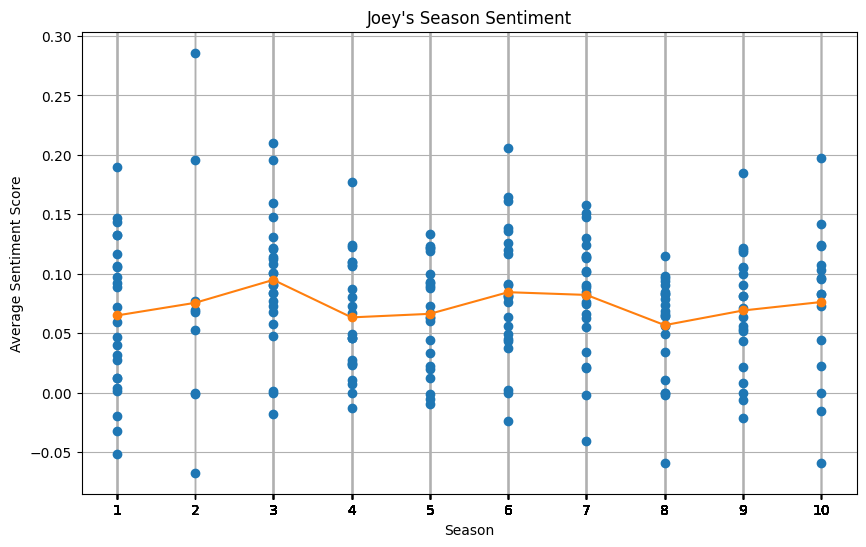

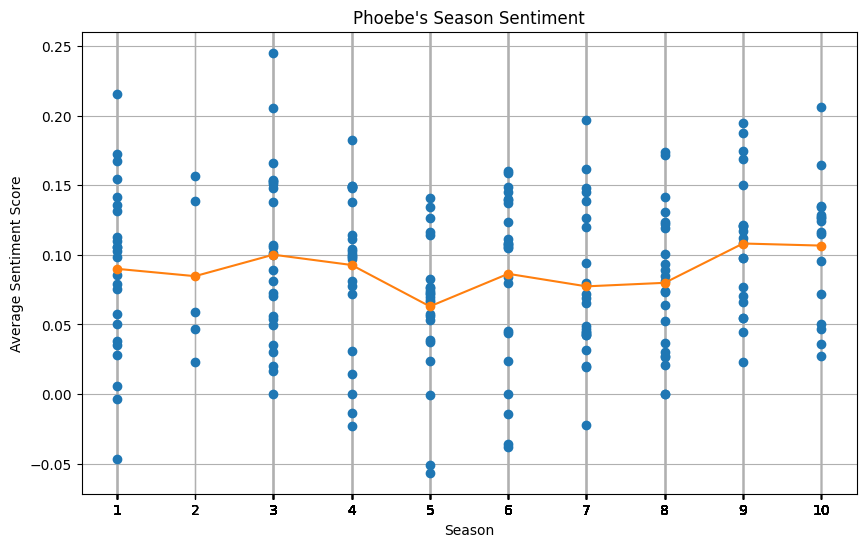

In [ ]:
# Plot season sentiment for each character
plt.figure(figsize=(10, 6))
plt.plot(rachel_lines['season'], rachel_lines['sentiment_score'],linestyle='None', marker='o')
plt.plot(rachel_sentiment_stats.index, rachel_sentiment_stats['mean'], marker='o')
plt.title("Rachel's Season Sentiment")
plt.xlabel('Season')
plt.ylabel('Average Sentiment Score')
plt.xticks(rachel_lines['season'])
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(ross_lines['season'], ross_lines['sentiment_score'],linestyle='None', marker='o')
plt.plot(ross_sentiment_stats.index, ross_sentiment_stats['mean'], marker='o')
plt.title("Ross's Season Sentiment")
plt.xlabel('Season')
plt.ylabel('Average Sentiment Score')
plt.xticks(ross_lines['season'])
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(monica_lines['season'], monica_lines['sentiment_score'],linestyle='None', marker='o')
plt.plot(monica_sentiment_stats.index, monica_sentiment_stats['mean'], marker='o')
plt.title("Monica's Season Sentiment")
plt.xlabel('Season')
plt.ylabel('Average Sentiment Score')
plt.xticks(monica_lines['season'])
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(chandler_lines['season'], chandler_lines['sentiment_score'],linestyle='None', marker='o')
plt.plot(chandler_sentiment_stats.index, chandler_sentiment_stats['mean'], marker='o')
plt.title("Chandler's Season Sentiment")
plt.xlabel('Season')
plt.ylabel('Average Sentiment Score')
plt.xticks(chandler_lines['season'])
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(joey_lines['season'], joey_lines['sentiment_score'],linestyle='None', marker='o')
plt.plot(joey_sentiment_stats.index, joey_sentiment_stats['mean'], marker='o')
plt.title("Joey's Season Sentiment")
plt.xlabel('Season')
plt.ylabel('Average Sentiment Score')
plt.xticks(joey_lines['season'])
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(phoebe_lines['season'], phoebe_lines['sentiment_score'],linestyle='None', marker='o')
plt.plot(phoebe_sentiment_stats.index, phoebe_sentiment_stats['mean'], marker='o')
plt.title("Phoebe's Season Sentiment")
plt.xlabel('Season')
plt.ylabel('Average Sentiment Score')
plt.xticks(phoebe_lines['season'])
plt.grid(True)
plt.show()

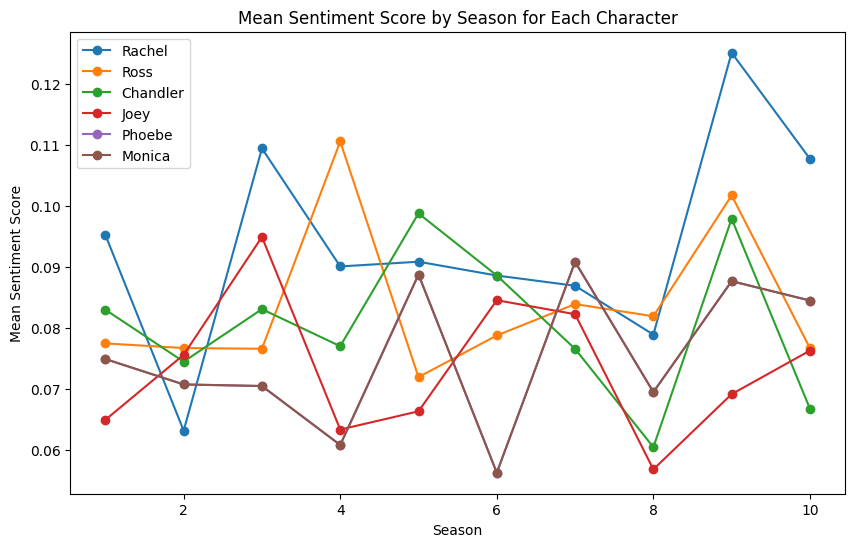

In [ ]:
# Plot mean sentiment scores
plt.figure(figsize=(10, 6))

rachel_sentiment_stats = rachel_lines.groupby('season')['sentiment_score'].agg(['mean', 'std'])
ross_sentiment_stats = ross_lines.groupby('season')['sentiment_score'].agg(['mean', 'std'])
chandler_sentiment_stats = chandler_lines.groupby('season')['sentiment_score'].agg(['mean', 'std'])
joey_sentiment_stats = joey_lines.groupby('season')['sentiment_score'].agg(['mean', 'std'])
monica_sentiment_stats = monica_lines.groupby('season')['sentiment_score'].agg(['mean', 'std'])
phoebe_sentiment_stats = monica_lines.groupby('season')['sentiment_score'].agg(['mean', 'std'])

plt.plot(rachel_sentiment_stats.index, rachel_sentiment_stats['mean'], marker='o', label='Rachel')
plt.plot(ross_sentiment_stats.index, ross_sentiment_stats['mean'], marker='o', label='Ross')
plt.plot(chandler_sentiment_stats.index, chandler_sentiment_stats['mean'], marker='o', label='Chandler')
plt.plot(joey_sentiment_stats.index, joey_sentiment_stats['mean'], marker='o', label='Joey')
plt.plot(phoebe_sentiment_stats.index, phoebe_sentiment_stats['mean'], marker='o', label='Phoebe')
plt.plot(monica_sentiment_stats.index, monica_sentiment_stats['mean'], marker='o', label='Monica')

plt.title("Mean Sentiment Score by Season for Each Character")
plt.xlabel('Season')
plt.ylabel('Mean Sentiment Score')

# Display the legend
plt.legend(loc='best')  # 'best' finds the optimal position for the legend

# Show the plot
plt.show()

In [ ]:
groupedEpisode = episode_char_df.groupby(['season', 'episode'])['dialogue'].agg(lambda x: ' '.join(x))
groupedEpisode = groupedEpisode.reset_index();
groupedEpisode['preprocessed_dialogue'] = groupedEpisode['dialogue'].apply(lambda x: preprocess_dialog(x))
groupedEpisode

,season,episode,dialogue,preprocessed_dialogue
0,1,01,There's nothing to tell! He's just some guy\nI...,there's nothing tell he's guy work c'mon going...
1,1,02,"What you guys don't understand is, for us,\nki...",guys understand us kissing important part righ...
2,1,03,"(entering) Hi guys! Hey. Oh, oh, how'd it go? ...",entering hi guys hey how'd good walked subway ...
3,1,04,"Alright. Phoebe? Okay, okay. If I were omnipot...",alright phoebe omnipotent day would want world...
4,1,05,Would you let it go? It's not that big a deal....,would let big deal big deal amazing reach ther...
...,...,...,...,...
210,10,12,"Oh, hey Joey. Uh, hey. Listen, I need to ask y...",hey joey hey listen need ask something step da...
211,10,13,"Hi How was the honeymoon? Oh! So, where's Mike...",hi honeymoon where's mike he's doctor poop who...
212,10,14,"Oh! Yeah, this is fun, couples night. Yeah, I ...",fun couples night hang married couples often w...
213,10,15,How did the job stuff go? He offered me one. (...,job stuff offered one gasps calls bottle israe...


In [ ]:
groupedEpisode = groupedEpisode.drop(30)
groupedEpisode = groupedEpisode.drop(33)
groupedEpisode = groupedEpisode.drop(190)

In [ ]:
groupedEpisode

,season,episode,dialogue,preprocessed_dialogue
0,1,01,There's nothing to tell! He's just some guy\nI...,there's nothing tell he's guy work c'mon going...
1,1,02,"What you guys don't understand is, for us,\nki...",guys understand us kissing important part righ...
2,1,03,"(entering) Hi guys! Hey. Oh, oh, how'd it go? ...",entering hi guys hey how'd good walked subway ...
3,1,04,"Alright. Phoebe? Okay, okay. If I were omnipot...",alright phoebe omnipotent day would want world...
4,1,05,Would you let it go? It's not that big a deal....,would let big deal big deal amazing reach ther...
...,...,...,...,...
210,10,12,"Oh, hey Joey. Uh, hey. Listen, I need to ask y...",hey joey hey listen need ask something step da...
211,10,13,"Hi How was the honeymoon? Oh! So, where's Mike...",hi honeymoon where's mike he's doctor poop who...
212,10,14,"Oh! Yeah, this is fun, couples night. Yeah, I ...",fun couples night hang married couples often w...
213,10,15,How did the job stuff go? He offered me one. (...,job stuff offered one gasps calls bottle israe...


In [ ]:
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

In [ ]:
# Apply sentiment analysis to each episode's dialogue
groupedEpisode['sentiment_polarity'] = groupedEpisode['preprocessed_dialogue'].apply(get_sentiment)

In [ ]:
groupedEpisode

,season,episode,dialogue,preprocessed_dialogue,sentiment_polarity
0,1,01,There's nothing to tell! He's just some guy\nI...,there's nothing tell he's guy work c'mon going...,0.123346
1,1,02,"What you guys don't understand is, for us,\nki...",guys understand us kissing important part righ...,0.095469
2,1,03,"(entering) Hi guys! Hey. Oh, oh, how'd it go? ...",entering hi guys hey how'd good walked subway ...,0.074029
3,1,04,"Alright. Phoebe? Okay, okay. If I were omnipot...",alright phoebe omnipotent day would want world...,0.088928
4,1,05,Would you let it go? It's not that big a deal....,would let big deal big deal amazing reach ther...,0.125365
...,...,...,...,...,...
210,10,12,"Oh, hey Joey. Uh, hey. Listen, I need to ask y...",hey joey hey listen need ask something step da...,0.092714
211,10,13,"Hi How was the honeymoon? Oh! So, where's Mike...",hi honeymoon where's mike he's doctor poop who...,0.101589
212,10,14,"Oh! Yeah, this is fun, couples night. Yeah, I ...",fun couples night hang married couples often w...,0.121195
213,10,15,How did the job stuff go? He offered me one. (...,job stuff offered one gasps calls bottle israe...,0.155835


In [ ]:
# Find indices where season changes occur
season_change_indices = groupedEpisode.index[groupedEpisode['season'].diff() != 0].tolist()

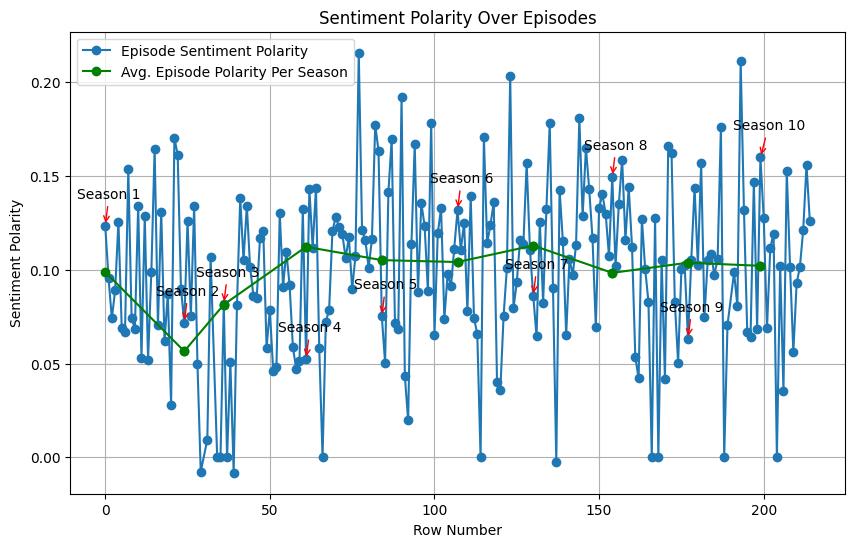

In [ ]:
# Calculate average sentiment polarity for each season
season_avg_sentiment = groupedEpisode.groupby('season')['sentiment_polarity'].mean()

# Find indices of the beginning episode of each season
season_beginning_indices = groupedEpisode.groupby('season').head(1).index

# Find indices where season changes occur
season_change_indices = groupedEpisode.index[groupedEpisode['season'].diff() != 0].tolist()

# Plot sentiment polarity over rows
plt.figure(figsize=(10, 6))
plt.plot(groupedEpisode.index, groupedEpisode['sentiment_polarity'], marker='o', linestyle='-', label='Episode Sentiment Polarity')

# Annotate season change points
for index in season_change_indices:
    plt.annotate(f'Season {groupedEpisode.at[index, "season"]}', xy=(index, groupedEpisode.at[index, 'sentiment_polarity']),
                 xytext=(-20, 20), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='r'))


# Plot average sentiment polarity for each season
for i in range(len(season_beginning_indices) - 1):
    start_index = season_beginning_indices[i]
    end_index = season_beginning_indices[i+1]
    plt.plot([start_index, end_index], [season_avg_sentiment.iloc[i], season_avg_sentiment.iloc[i+1]], marker='o', linestyle='-', color='g')



# Plot the last average sentiment point
plt.plot(season_beginning_indices[-1], season_avg_sentiment.iloc[-1], marker='o', linestyle='-', color='g', label = 'Avg. Episode Polarity Per Season')

plt.title('Sentiment Polarity Over Episodes')
plt.xlabel('Row Number')
plt.ylabel('Sentiment Polarity')
plt.legend()
plt.grid(True)
plt.show()

# TF-IDF Scores

In [ ]:
groupedEpisode['tokenized_dialogue'] = groupedEpisode['preprocessed_dialogue'].apply(lambda x: word_tokenize(x))

word_lemma = WordNetLemmatizer()
#lemmatize word to root form(ex. cars to car, things to thing)
def lemma(txt):
    l_txt = [word_lemma.lemmatize(w) for w in txt]
    return l_txt

#lemmatize verbs to root form(ex. running to run, making to make)
def lemma_as_verb(txt):
    l_txt = [word_lemma.lemmatize(w, pos='v') for w in txt]  # Assume every word is a verb
    return l_txt


groupedEpisode['tokenized_dialogue'] = groupedEpisode['tokenized_dialogue'].apply(lambda x:lemma(x))
groupedEpisode['tokenized_dialogue'] = groupedEpisode['tokenized_dialogue'].apply(lambda x:lemma_as_verb(x))
groupedEpisode.head()

,season,episode,dialogue,preprocessed_dialogue,sentiment_polarity,tokenized_dialogue
0,1,01,There's nothing to tell! He's just some guy\nI...,there's nothing tell he's guy work c'mon going...,0.123346,"[there, 's, nothing, tell, he, 's, guy, work, ..."
1,1,02,"What you guys don't understand is, for us,\nki...",guys understand us kissing important part righ...,0.095469,"[guy, understand, u, kiss, important, part, ri..."
2,1,03,"(entering) Hi guys! Hey. Oh, oh, how'd it go? ...",entering hi guys hey how'd good walked subway ...,0.074029,"[enter, hi, guy, hey, how, 'd, good, walk, sub..."
3,1,04,"Alright. Phoebe? Okay, okay. If I were omnipot...",alright phoebe omnipotent day would want world...,0.088928,"[alright, phoebe, omnipotent, day, would, want..."
4,1,05,Would you let it go? It's not that big a deal....,would let big deal big deal amazing reach ther...,0.125365,"[would, let, big, deal, big, deal, amaze, reac..."


In [ ]:
tfidf_vectorizer = TfidfVectorizer()

groupedEpisode['preprocessed_dialogue'] = groupedEpisode['tokenized_dialogue'].apply(lambda x: ' '.join(x))

tfidf_weights = tfidf_vectorizer.fit_transform(groupedEpisode['preprocessed_dialogue'])

tfidf_df = pd.DataFrame(tfidf_weights.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


top_words_per_row = tfidf_df.apply(lambda row: row.nlargest(20).index.tolist(), axis=1)

top_words_and_scores_per_row = tfidf_df.apply(lambda row: [(word, row[word]) for word in row.nlargest(20).index], axis=1)

groupedEpisode['top_20_words'] = top_words_per_row

In [ ]:
# Filter DataFrame for specific season and episode
def plotTopWords(s, e):

  # Ensure DataFrame indices are reset and aligned
  groupedEpisode.reset_index(drop=True, inplace=True)

  target = top_words_and_scores_per_row[(groupedEpisode['season'] == s) & (groupedEpisode['episode'] == e)].iloc[0]

  # Unpack words and scores
  words, scores = zip(*target)

  # Plot top words and their TF-IDF scores for Season 7, Episode 21
  plt.figure(figsize=(10, 6))
  plt.bar(words, scores)
  plt.title(f'Top 20 Words and Their TF-IDF Scores for Season {s}, Episode {e}')
  plt.xlabel('Words')
  plt.ylabel('TF-IDF Score')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()

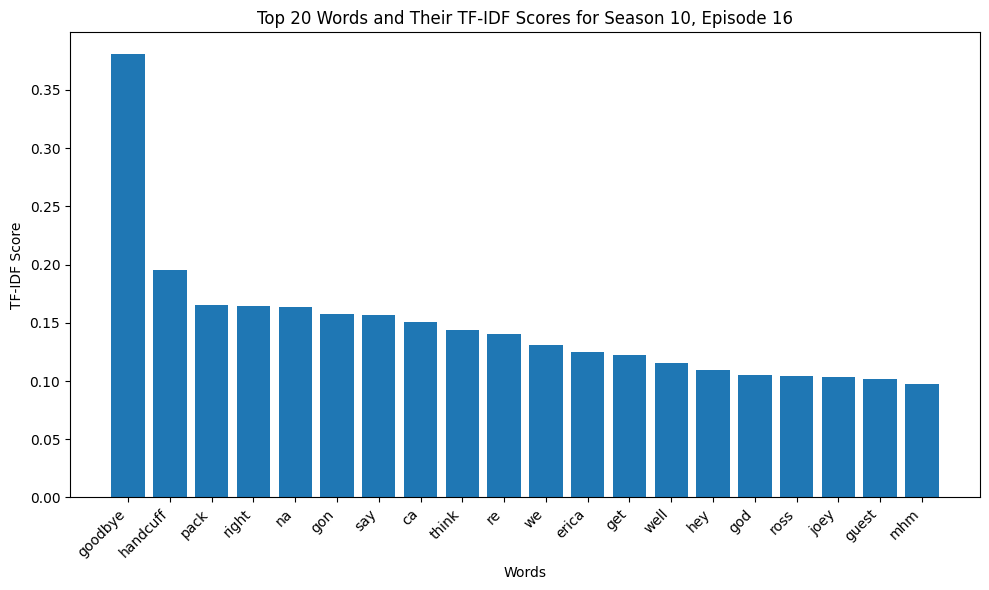

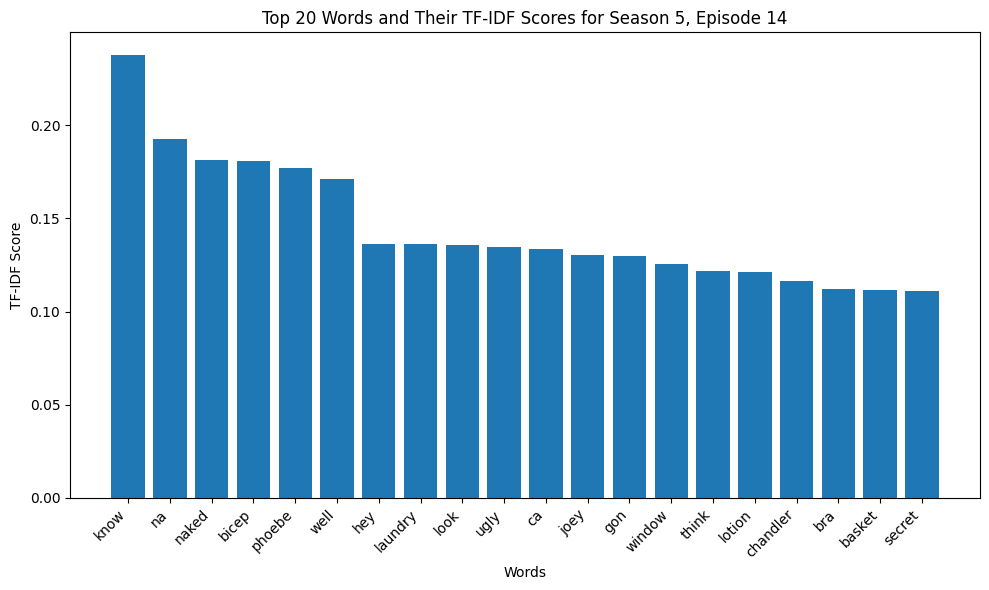

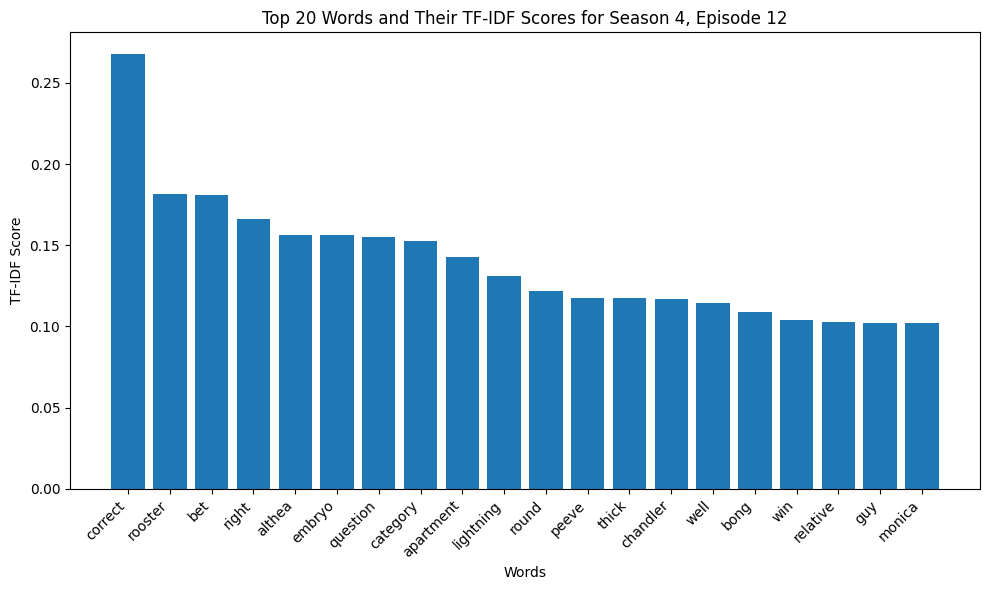

In [ ]:
plotTopWords(10, "16")
plotTopWords(5, "14")
plotTopWords(4, "12")